# Load Libraries

---



In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import gdown
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product


# Load Data

---


In [ ]:
# # download Data from google drive
# gdown.download(
#     id="1-bNSbMCJvcxVsxvsiEHaPHIQBlLiFQgu",
#     output="divorce_all_model.csv",
#     quiet=False
# )


Downloading...
From: https://drive.google.com/uc?id=1-bNSbMCJvcxVsxvsiEHaPHIQBlLiFQgu
To: c:\Users\nanta\Desktop\TestAntigravity\divorce_all_model.csv
100%|██████████| 3.89k/3.89k [00:00<00:00, 10.3MB/s]


'divorce_all_model.csv'

In [ ]:
# Load CSV
df_prophet = pd.read_csv("divorce_all_model.csv")

# Convert ds to datetime
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

# Rename target column
df_prophet = df_prophet.rename(columns={"Divorce": "y"})

# Sort by date
df_prophet = df_prophet.sort_values("ds")

# Prophet-ready DataFrame
df_p = df_prophet[["ds", "y"]].copy()


In [ ]:
# Prophet-ready dataframe
df_for_tuning = df_prophet[['ds', 'y']].copy()

# cap / floor (เผื่อใช้ logistic ในอนาคต)
global_cap = df_for_tuning['y'].max() * 1.2
global_floor = 0


# Grid Search | Hyperparameter Tuning


---



จาก Official ด้านวิธีการทำ ตรงหัวข้อ

> ***Hyperparameter Tuning***

* https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

กระทู้ใน Stack Overflow ที่ทำ Hyperparameter Tuning สำหรับ Meta Prophet เหมือนกัน

*   https://stackoverflow.com/questions/69856048/hyperparameter-tuning-fb-prophet-model-how-to-reference-m-add-seasonality-cate


In [11]:
# สร้าง Parameter สำหรับการทำ Search Hyperparameter Tuning
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 0.95, 1.0], 
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 3.0, 5.0, 7.0, 10.0],
    "yearly_seasonality": [True],
    "weekly_seasonality": [False],
    "daily_seasonality": [False]
}

In [12]:
df_for_tuning = df_prophet.reset_index()[['ds', 'y']]

In [13]:
global_cap = df_for_tuning['y'].max() * 1.2
global_floor = 0

In [21]:
def tune_prophet_hyperparameters_simple(df, cap, floor):

    all_params = [
        dict(zip(param_grid.keys(), v))
        for v in product(*param_grid.values())
    ]

    results = []

    for params in all_params:
        try:
            df_tmp = df.copy()

            # Safety check
            if 'ds' not in df_tmp.columns or 'y' not in df_tmp.columns:
                raise ValueError("DataFrame must contain 'ds' and 'y' columns")

            model = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                yearly_seasonality=params['yearly_seasonality'],
                weekly_seasonality=params['weekly_seasonality'],
                daily_seasonality=params['daily_seasonality']
            )

            model.fit(df_tmp)
            forecast = model.predict(df_tmp)

            y_true = df_tmp['y'].values
            y_pred = forecast['yhat'].values

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            results.append({
                **params,
                "mae": mae,
                "rmse": rmse,
                "mape": mape
            })

        except Exception as e:
            print(f"❌ Skipping params {params} → {e}")
            continue

    if len(results) == 0:
        raise RuntimeError("No successful model fits. Check your data.")

    results_df = pd.DataFrame(results)

    best_row = results_df.sort_values("mape").iloc[0]
    best_params = {
        k: best_row[k]
        for k in param_grid.keys()
    }

    return best_params, results_df


In [22]:
best_params, tuning_results = tune_prophet_hyperparameters_simple(
    df=df_for_tuning,
    cap=global_cap,
    floor=global_floor
)


23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1]

In [30]:
best_row = tuning_results.loc[tuning_results['mape'].idxmin()]
print(best_row)


changepoint_prior_scale           1.0
seasonality_prior_scale           0.1
yearly_seasonality               True
weekly_seasonality              False
daily_seasonality               False
mae                        283.878189
rmse                       444.986871
mape                         4.273628
Name: 57, dtype: object


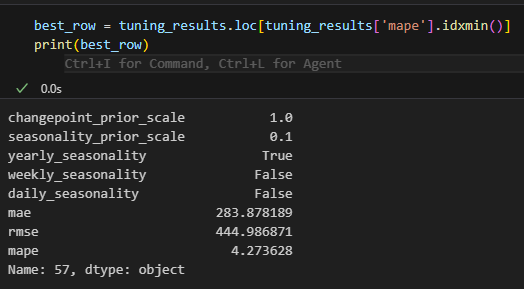

In [32]:
print(df_for_tuning)
print(df_for_tuning.columns)
print(len(df_for_tuning))


            ds       y
0   2007-01-01  6568.0
1   2007-02-01  5963.0
2   2007-03-01  6388.0
3   2007-04-01  6696.0
4   2007-05-01  6298.0
..         ...     ...
211 2024-08-01  7929.0
212 2024-09-01  7618.0
213 2024-10-01  8618.0
214 2024-11-01  7953.0
215 2024-12-01  7444.0

[216 rows x 2 columns]
Index(['ds', 'y'], dtype='object')
216


In [34]:
df_p = df_prophet.reset_index()[['ds', 'y']].copy()


In [35]:
df_p['cap'] = global_cap
df_p['floor'] = global_floor

In [41]:
# Parameters
params = {
    'changepoint_prior_scale': 1,
    'seasonality_prior_scale': 0.1,
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False
}

model = Prophet(
    growth='logistic',
    **params
)

model.fit(df_p)

future = model.make_future_dataframe(
    periods=60,
    freq='MS'
)

future['cap'] = global_cap
future['floor'] = global_floor

forecast = model.predict(future)



23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(
    x=df_p['ds'],
    y=df_p['y'],
    mode='lines',
    name='Actual',
    line=dict(width=2)
))

# Forecast line
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Forecast',
    line=dict(dash='dash', width=2)
))

# Confidence interval
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    fill='tonexty',
    line=dict(width=0),
    opacity=0.25,
    showlegend=False
))

fig.update_layout(
    title="Prophet Forecast (Plotly)",
    xaxis_title="Date",
    yaxis_title="Divorce Count",
    hovermode="x unified",
    template="plotly_white",
    height=550
)

fig.show()


In [43]:
metric_df = (
    forecast[['ds', 'yhat']]
    .merge(df_p[['ds', 'y']], on='ds', how='inner')
)

y_true = metric_df['y']
y_pred = metric_df['yhat']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"MAE : {mae:.2f}")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE : 287.10
MSE : 204651.72
RMSE: 452.38
MAPE: 4.34%
